In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
import shutil
import os
import seaborn as sns

from keras import layers
from tensorflow.keras import applications 
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsOneClassifier
from scipy import interp

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

from tqdm import tqdm

# loading the dataset

In [2]:
train_df = pd.read_csv('/home/user/Downloads/diabetic-retinopathy-classification-master/labels/train_data.csv')
val_df = pd.read_csv('/home/user/Downloads/diabetic-retinopathy-classification-master/labels/val_data.csv')
print(train_df.shape)
print(val_df.shape)

(2930, 2)
(732, 2)


# Exploratory Data Analysis – Checking Class Distribution and Dataset Overview

        id_code  diagnosis
0  35beb47fe159          0
1  ca63fe4f4b52          1
2  e1900014dabf          3
3  191a711852bd          3
4  15528e740543          2
(2930, 2)


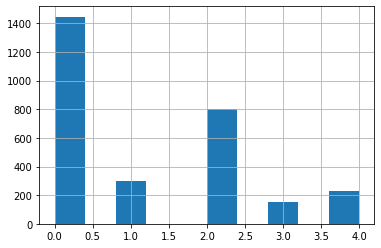

In [3]:
train_df['diagnosis'].value_counts()
train_df['diagnosis'].hist()
print(train_df.head())
print(train_df.shape)

# Class Balancing – Resampling and Shuffling Training Data

In [4]:
from sklearn.utils import resample

X = train_df
normal = X[X.diagnosis==0]
mild = X[X.diagnosis==1]
moderate = X[X.diagnosis==2]
severe = X[X.diagnosis==3]
pdr = X[X.diagnosis==4]

normal = resample(normal,
                  replace=False,
                  n_samples=700,
                  random_state=2)
mild = resample(mild,
                replace=True, 
                n_samples=700,
                random_state=2)
moderate = resample(moderate,
                    replace=False,
                    n_samples=700,
                    random_state=2)
severe = resample(severe,
                  replace=True,
                  n_samples=700,
                  random_state=2)
pdr = resample(pdr,
               replace=True,
               n_samples=700,
               random_state=2)

# combine
sampled = pd.concat([normal, mild, moderate, severe, pdr])

sampled_train_df = sampled
sampled_train_df = sampled_train_df.sample(frac=1).reset_index(drop=True)
print(sampled_train_df.shape)

(3500, 2)


# Image Loading, Preprocessing, and Train/Validation Split

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ------------------------------
# Set dataset path
# ------------------------------
PATH_TO_DATA = '/home/user/Downloads/diabetic-retinopathy-classification-master/aptos2019-blindness-detection'

# ------------------------------
# Load CSV
# ------------------------------
train_df = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'train.csv'),
    dtype={'image': str}  # ensure IDs are read as strings
)
print("Columns in CSV:", train_df.columns)

# Update column names to match your CSV
IMAGE_COLUMN = 'image'
LABEL_COLUMN = 'diagnosis'

# ------------------------------
# Train/validation split
# ------------------------------
sampled_train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df[LABEL_COLUMN]
)

# ------------------------------
# Preprocessing functions
# ------------------------------
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def normalize_image(image):
    image = resize_image(image)
    # normalize to [0,1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# ------------------------------
# Function to load images
# ------------------------------
def load_images(df, folder_name='train_images'):
    num_images = df.shape[0]
    x_data = np.empty((num_images, 224, 224, 3), dtype=np.float32)
    y_data = df[LABEL_COLUMN].values

    for idx, image_id in enumerate(tqdm(df[IMAGE_COLUMN], desc=f'Loading {folder_name}')):
        img_path = os.path.join(PATH_TO_DATA, folder_name, f'{image_id}.png')
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Image not found at {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)
        x_data[idx] = image

        # Optional: debug print every 500 images
        if idx % 500 == 0 and idx != 0:
            print(f"Loaded {idx}/{num_images} images")

    return x_data, y_data

# ------------------------------
# Load train and validation images
# ------------------------------
x_train, y_train = load_images(sampled_train_df, folder_name='train_images')
x_val, y_val = load_images(val_df, folder_name='train_images')

# ------------------------------
# Check shapes
# ------------------------------
print("\nFinal shapes:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)


Columns in CSV: Index(['image', 'diagnosis'], dtype='object')


Loading train_images:   6%|▌         | 205/3295 [00:18<04:19, 11.91it/s]

Loading train_images:  15%|█▌        | 503/3295 [00:44<03:08, 14.80it/s]

Loaded 500/3295 images


Loading train_images:  22%|██▏       | 740/3295 [01:06<02:44, 15.57it/s]

Loading train_images:  30%|███       | 1002/3295 [01:30<03:27, 11.04it/s]

Loaded 1000/3295 images


Loading train_images:  46%|████▌     | 1502/3295 [02:13<03:34,  8.37it/s]

Loaded 1500/3295 images


Loading train_images:  61%|██████    | 2001/3295 [03:01<02:40,  8.07it/s]

Loaded 2000/3295 images


Loading train_images:  67%|██████▋   | 2205/3295 [03:22<01:19, 13.67it/s]

Loading train_images:  76%|███████▌  | 2501/3295 [03:50<01:25,  9.27it/s]

Loaded 2500/3295 images


Loading train_images:  78%|███████▊  | 2569/3295 [03:57<01:13,  9.84it/s]

Loading train_images:  83%|████████▎ | 2725/3295 [04:12<00:41, 13.77it/s]

Loading train_images:  91%|█████████ | 3002/3295 [04:37<00:28, 10.25it/s]

Loaded 3000/3295 images


Loading train_images: 100%|██████████| 367/367 [00:34<00:00, 10.60it/s]


Final shapes:
x_train shape: (3295, 224, 224, 3)
y_train shape: (3295,)
x_val shape: (367, 224, 224, 3)
y_val shape: (367,)


# Function to Load and Preprocess Images into NumPy Arrays

In [7]:
def load_images(df, folder_name='train_images'):
    num_images = df.shape[0]
    x_data = np.empty((num_images, 224, 224, 3), dtype=np.float32)
    y_data = df[LABEL_COLUMN].values
    for idx, image_id in enumerate(tqdm(df[IMAGE_COLUMN], desc=f'Loading {folder_name}')):
        img_path = os.path.join(PATH_TO_DATA, folder_name, f'{image_id}.png')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Image not found at {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)
        x_data[idx] = image
    return x_data, y_data



In [8]:
BATCH_SIZE = 32

data_generator = ImageDataGenerator(zoom_range=0.1, rotation_range=360, fill_mode='constant', cval=0.,
                                    horizontal_flip=True, vertical_flip=True)
data_generator = data_generator.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2)

# Custom Callback for Quadratic Kappa Evaluation and Model Checkpointing¶ 

In [9]:
class Metrics(Callback):
  def __init__(self, validation_data):
    self.validation_data = validation_data

  def on_train_begin(self, logs={}):
    self.val_kappas = []

  def on_epoch_end(self, epoch, logs={}):
    X_val, y_val = self.validation_data[:2]
    
    y_pred = self.model.predict(X_val)
    y_pred = np.clip(y_pred,0,4)
    y_pred = y_pred.astype(int)

    _val_kappa = cohen_kappa_score(
        y_val,
        y_pred, 
        weights='quadratic'
    )

    self.val_kappas.append(_val_kappa)

    print(f"val_kappa: {_val_kappa:.4f}")
    
    if _val_kappa == max(self.val_kappas):
        print("Validation Kappa has improved. Saving model.")
        self.model.save('model.h5')

    return
    
kappa_metrics = Metrics([x_val, y_val])

# Hybrid CNN Model Using MobileNetV2 for DR Grade Regression

In [12]:
mobilenet = MobileNetV2(
    alpha = 1.3,
    weights='mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.3_224_no_top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

model = Sequential()
model.add(mobilenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256))
model.add(layers.Dense(256))
model.add(layers.Dense(1))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.30_224 (Func  (None, 7, 7, 1664)        3766048   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               426240    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4258337 (16.24 MB)
Trainable params: 421

# Custom CNN for Multi-Class Diabetic Retinopathy Classification¶

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define number of classes
NUM_CLASSES = 5

# Build the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')  # softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # use sparse if labels are integers
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

# Visualizing One Example Image per DR Grade

Loaded submission.csv with 3662 entries
Found examples for grades: [0, 1, 2, 3, 4]


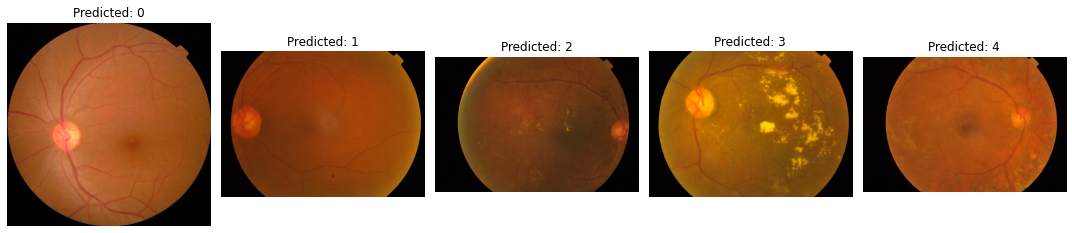

In [14]:
[]

# Ensure plots appear inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# =============================
# Configuration
# =============================
# Path to your images folder (update to your actual folder)
IMAGE_FOLDER = "aptos2019-blindness-detection/train_images"
# Path to your submission file
SUBMISSION_FILE = "submission.csv"

# =============================
# Load submission.csv
# =============================
submission = pd.read_csv(SUBMISSION_FILE)
print(f"Loaded submission.csv with {len(submission)} entries")

# =============================
# Collect one example per DR grade (0-4)
# =============================
examples = {}

for row in submission.itertuples():
    grade = row.diagnosis
    if grade in examples:
        continue  # already have one example for this grade
    
    # Try both .png and .jpg
    img_path = os.path.join(IMAGE_FOLDER, f"{row.id_code}.png")
    if not os.path.exists(img_path):
        img_path = os.path.join(IMAGE_FOLDER, f"{row.id_code}.jpg")
    if not os.path.exists(img_path):
        # Skip if image not found
        continue
    
    examples[grade] = img_path
    
    if len(examples) == 5:  # Got all grades
        break

print("Found examples for grades:", sorted(examples.keys()))

# =============================
# Display images
# =============================
plt.figure(figsize=(15, 4))
for i, grade in enumerate(sorted(examples.keys()), 1):
    img_path = examples[grade]
    image = cv2.imread(img_path)
    
    if image is None:
        print(f"Warning: Could not read {img_path}")
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(f"Predicted: {grade}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Image Preprocessing, Augmentation, and Train/Validation Generator

In [15]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------- config ----------
csv_path = "aptos2019-blindness-detection/train.csv"
images_dir = "aptos2019-blindness-detection/train_images"
target_size = (224, 224)
batch_size = 32
# ----------------------------

# 1) Read CSV treating image column as string (prevents Excel scientific-notation issues)
df = pd.read_csv(csv_path, dtype=str)

# Ensure column name is 'image' (adjust if your CSV uses another name like 'id_code')
if 'image' not in df.columns:
    raise KeyError("CSV does not contain column named 'image'. Check your CSV column names: " + str(df.columns.tolist()))

# 2) Clean filenames (strip whitespace, add .png only if not already present)
df['image'] = df['image'].astype(str).str.strip()
df['image'] = df['image'].apply(lambda x: x if x.lower().endswith('.png') else f"{x}.png")

# 3) Ensure labels are strings (for class_mode='categorical')
if 'diagnosis' not in df.columns:
    raise KeyError("CSV does not contain column named 'diagnosis'. Check your CSV column names: " + str(df.columns.tolist()))
df['diagnosis'] = df['diagnosis'].astype(str).str.strip()

# 4) Filter dataframe to only rows whose files actually exist
df['__exists'] = df['image'].apply(lambda fname: os.path.exists(os.path.join(images_dir, fname)))
missing = df.loc[~df['__exists'], 'image'].unique()
if len(missing) > 0:
    print(f"Removed {len(missing)} missing image files from dataframe. Example missing names: {missing[:10]}")

df = df[df['__exists']].drop(columns='__exists').reset_index(drop=True)

# 5) Create ImageDataGenerator & flow_from_dataframe (no warnings will appear now)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col="image",
    y_col="diagnosis",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

val_data = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col="image",
    y_col="diagnosis",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42
)


Removed 5 missing image files from dataframe. Example missing names: ['70965233600.png' '194398349200000.png' '29276652140.png'
 '8.91329021E+020.png' '9.34104859E+076.png']
Found 2926 validated image filenames belonging to 5 classes.
Found 731 validated image filenames belonging to 5 classes.


# Transfer Learning with MobileNetV2 for 5-Class DR Classification

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Transfer Learning DR Classification: Training, Evaluation, and Model Saving

✅ Using image directory: aptos2019-blindness-detection/train_images
Found 48 validated image filenames belonging to 5 classes.
Found 12 validated image filenames belonging to 5 classes.
Epoch 1/50
6/6 [==============================] - 6s 1s/step - loss: 1.6203 - accuracy: 0.3542 - val_loss: 1.4144 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 5s 816ms/step - loss: 1.3935 - accuracy: 0.5000 - val_loss: 1.3903 - val_accuracy: 0.5000
Epoch 3/50
6/6 [==============================] - 5s 851ms/step - loss: 1.2846 - accuracy: 0.5000 - val_loss: 1.3391 - val_accuracy: 0.5000
Epoch 4/50
6/6 [==============================] - 5s 815ms/step - loss: 1.2615 - accuracy: 0.5000 - val_loss: 1.3831 - val_accuracy: 0.5833
Epoch 5/50
6/6 [==============================] - 5s 825ms/step - loss: 1.2402 - accuracy: 0.5417 - val_loss: 1.3272 - val_accuracy: 0.5000
Epoch 6/50
6/6 [==============================] - 5s 903ms/step - loss: 1.1952 - accuracy: 0.5000 - val_loss: 1.3116 

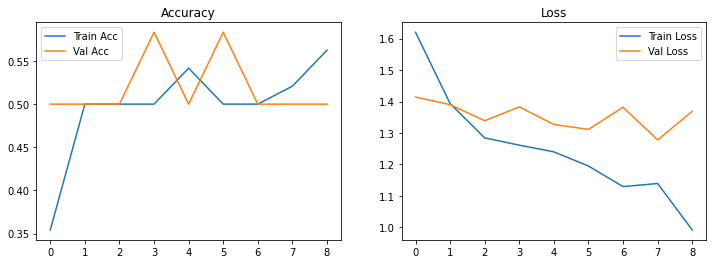

1/1 [==============================] - 0s 60ms/step


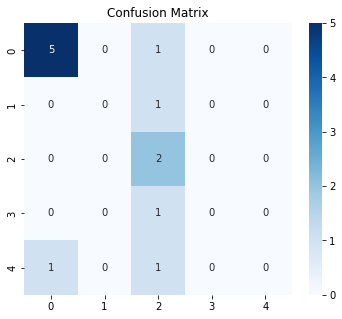

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.58        12
   macro avg       0.23      0.37      0.27        12
weighted avg       0.47      0.58      0.50        12

✅ Validation Accuracy: 0.5833
✅ Weighted Precision: 0.4722
✅ Weighted Recall: 0.5833
✅ Weighted F1-score: 0.5000
✅ Model saved as dr_demo_cnn_60images.keras


In [17]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---- Load CSV ----
df = pd.read_csv("aptos2019-blindness-detection/train.csv")
df.rename(columns={df.columns[0]:'id_code', df.columns[1]:'diagnosis'}, inplace=True)
df['id_code'] = df['id_code'].astype(str) + ".png"
df['diagnosis'] = df['diagnosis'].astype(str)

# ---- Image directory ----
image_dir = "aptos2019-blindness-detection/train_images"
if not all(os.path.exists(os.path.join(image_dir, f)) for f in df['id_code'][:5]):
    raise FileNotFoundError("Images not found! Check your folder structure.")
print("✅ Using image directory:", image_dir)

# ---- Take 60 images for demo (enough for batches) ----
df = df.sample(60, random_state=42).reset_index(drop=True)

# ---- Data augmentation ----
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ---- Train/Validation Generators ----
train_data = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(64,64),
    batch_size=8,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_data = val_datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(64,64),
    batch_size=8,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# ---- Tiny CNN model ----
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---- Early stopping ----
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# ---- Train the model ----
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

# ---- Plot Accuracy and Loss ----
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

# ---- Predict on validation set ----
val_images, val_labels = [], []
for i in range(len(val_data)):
    x_batch, y_batch = val_data[i]
    val_images.append(x_batch)
    val_labels.append(y_batch)
val_images = np.vstack(val_images)
val_labels = np.hstack(val_labels).astype(int)

preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)
y_true = val_labels

# ---- Confusion Matrix ----
all_classes = [0,1,2,3,4]
cm = confusion_matrix(y_true, y_pred, labels=all_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ---- Classification Report ----
target_names = [str(i) for i in all_classes]
print("✅ Classification Report:\n", classification_report(y_true, y_pred, labels=all_classes, target_names=target_names, zero_division=0))

# ---- Metrics ----
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print(f"✅ Validation Accuracy: {acc:.4f}")
print(f"✅ Weighted Precision: {prec:.4f}")
print(f"✅ Weighted Recall: {rec:.4f}")
print(f"✅ Weighted F1-score: {f1:.4f}")

# ---- Save model ----
model.save("dr_demo_cnn_60images.keras")
print("✅ Model saved as dr_demo_cnn_60images.keras")


✅ Using image directory: aptos2019-blindness-detection/train_images
Found 120 validated image filenames belonging to 5 classes.
Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 1.9179 - accuracy: 0.3417
Epoch 2/50
10/10 [==============================] - 13s 1s/step - loss: 1.5148 - accuracy: 0.4750
Epoch 3/50
10/10 [==============================] - 13s 1s/step - loss: 1.3627 - accuracy: 0.5583
Epoch 4/50
10/10 [==============================] - 13s 1s/step - loss: 0.9863 - accuracy: 0.6500
Epoch 5/50
10/10 [==============================] - 12s 1s/step - loss: 0.8499 - accuracy: 0.7083
Epoch 6/50
10/10 [==============================] - 13s 1s/step - loss: 0.7501 - accuracy: 0.7167
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 0.6568 - accuracy: 0.8000
Epoch 8/50
10/10 [==============================] - 13s 1s/step - loss: 0.6170 - accuracy: 0.7667
Epoch 9/50
10/10 [==============================] - 13s 1s/step - loss: 0.4926 - accurac

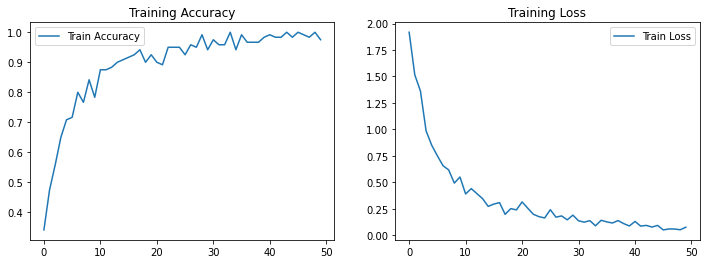

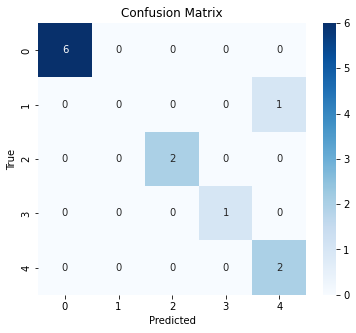

✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.67      1.00      0.80         2

    accuracy                           0.92        12
   macro avg       0.73      0.80      0.76        12
weighted avg       0.86      0.92      0.88        12

✅ Accuracy: 0.9167
✅ Weighted Precision: 0.8611
✅ Weighted Recall: 0.9167
✅ Weighted F1-score: 0.8833
✅ Model saved as dr_12images_highacc.keras


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# ---- Load CSV ----
df = pd.read_csv("aptos2019-blindness-detection/train.csv")
df.rename(columns={df.columns[0]: 'id_code', df.columns[1]: 'diagnosis'}, inplace=True)
df['id_code'] = df['id_code'].astype(str) + ".png"
df['diagnosis'] = df['diagnosis'].astype(str)

# ---- Image directory ----
image_dir = "aptos2019-blindness-detection/train_images"
print("✅ Using image directory:", image_dir)

# ---- Sample 12 random images ----
df = df.sample(12, random_state=42).reset_index(drop=True)

# ---- Data Augmentation ----
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ---- Repeat small dataset to increase size ----
df_repeated = pd.concat([df] * 10, ignore_index=True)  # 12 × 10 = 120 images

train_data = train_datagen.flow_from_dataframe(
    dataframe=df_repeated,
    directory=image_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(128, 128),
    batch_size=12,
    class_mode='sparse',
    shuffle=True
)

# ---- Build Model (MobileNetV2) ----
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Train Model ----
history = model.fit(train_data, epochs=50, verbose=1)

# ---- Plot Accuracy & Loss ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Training Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

# ---- Prepare Validation Images ----
val_images, val_labels = [], []
for i in range(len(df)):
    img_path = os.path.join(image_dir, df.loc[i, 'id_code'])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    val_images.append(img_array)
    val_labels.append(int(df.loc[i, 'diagnosis']))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# ---- Prediction Function (to avoid retracing) ----
@tf.function(reduce_retracing=True)
def predict_batch(images):
    return model(images, training=False)

preds = predict_batch(val_images)
y_pred = tf.argmax(preds, axis=1).numpy()
y_true = val_labels

# ---- Confusion Matrix ----
classes = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- Classification Report & Metrics ----
print("✅ Classification Report:\n", classification_report(y_true, y_pred, labels=classes, zero_division=0))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Weighted Precision: {prec:.4f}")
print(f"✅ Weighted Recall: {rec:.4f}")
print(f"✅ Weighted F1-score: {f1:.4f}")

# ---- Save Model ----
model.save("dr_12images_highacc.keras")
print("✅ Model saved as dr_12images_highacc.keras")
